# Seattle Airbnb Open Data - Data Science blog Post 

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, 
this dataset describes the listing activity of homestays in Seattle, WA.

## 1. Business Understanding


I will focus on the three question below:

Three main Topic

#### Understating the property feature

#### Understanding the price feature
 
#### Under standing the customer review

### Questions
 
Q1. Checking the most common amenity avialable in the property

Q2. How many unverified host has verfied exact location and unverified exact location. And Vise Versa?

Q3. How increase rental of the property what words to use to name it and what words to using in descriptions?

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import re,string
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.impute import SimpleImputer
from nltk.corpus import stopwords,wordnet# stopwords to detect language
from nltk import wordpunct_tokenize,pos_tag # function to split up our words
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier


## 2. Data Understanding

In [2]:
c_df = pd.read_csv('calendar.csv')
c_df.head()

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN

In [3]:
l_df = pd.read_csv('listings.csv')
l_df.head()

id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits atop Queen Anne...   
4  Cozy family craftman house in beautiful neighb...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   
3                                                NaN   
4  Cozy family craftman house in beautiful neighb...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   
3  A charming apartment that sits atop Queen Anne...                none   
4  Cozy family craftman house in beautiful neighb...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   
3                                                NaN  ...                 NaN   
4  We are in the beautiful neighborhood of Queen ...  ...                 9.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   
3                f     NaN         WASHINGTON                f   
4                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   
3            flexible                              f   
4              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   
3                                f                              1   
4                                f                              1   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  
3               NaN  
4              0.89  

[5 rows x 92 columns]

In [4]:
l_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [5]:
r_df = pd.read_csv('reviews.csv')
r_df.head()

listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...

### Data cleaning

In [6]:

def cleaning(list_df, cal_df, review_df):
    """
    Return cleaned datasets with all string variables for price, weekly_price, monthly_price,
    security_deposit, cleaning_fee, extra_people replaced with float variables without the dollar
    sign $. Also replace all string variables for host_response_rate, host_acceptance_rate with
    float variables without the percentage sign %. Lastly convert all dates in reviews and calendar
    dataframe with datetime.
    
    INPUTS:
        list_df - dataframe for listings
        cal_df - dataframe for calendar
        review_df - dataframe for reviews
    OUTPUTS:
        list_df - cleaned dataframe for listings. 
        cal_df - cleaned dataframe for calendar
        review_df - cleaned dataframe for reviews

    """
    # Convert string of prices to floats
    list_df.price=list_df.price.str.replace('$','')
    list_df.price=list_df.price.str.replace(',','').astype(float)

    list_df.weekly_price=list_df.weekly_price.str.replace('$','')
    list_df.weekly_price=list_df.weekly_price.str.replace(',','').astype(float)

    list_df.monthly_price=list_df.monthly_price.str.replace('$','')
    list_df.monthly_price=list_df.monthly_price.str.replace(',','').astype(float)

    list_df.security_deposit=list_df.security_deposit.str.replace('$','')
    list_df.security_deposit=list_df.security_deposit.str.replace(',','').astype(float)

    list_df.cleaning_fee=list_df.cleaning_fee.str.replace('$','')
    list_df.cleaning_fee=list_df.cleaning_fee.str.replace(',','').astype(float)

    list_df.extra_people=list_df.extra_people.str.replace('$','')
    list_df.extra_people=list_df.extra_people.str.replace(',','').astype(float)

    cal_df.price = cal_df.price.str.replace('$','')
    cal_df.price = cal_df.price.str.replace(',','').astype(float)

    # Convert string of pecentages to floats
    list_df.host_response_rate = list_df.host_response_rate.str.replace('%','')
    list_df.host_response_rate = list_df.host_response_rate.astype(float)

    list_df.host_acceptance_rate = list_df.host_acceptance_rate.str.replace('%','')
    list_df.host_acceptance_rate = list_df.host_acceptance_rate.astype(float)

    # Convert date string to datetime
    review_df['date'] = pd.to_datetime(review_df['date'], format='%Y-%m-%d')
    cal_df['date'] = pd.to_datetime(cal_df['date'], format='%Y-%m-%d')
    
    return list_df, cal_df, review_df

In [7]:
l_df, c_df, r_df = cleaning(l_df, c_df, r_df)
# Observe missing data
null_ratio = l_df.isnull().sum()/l_df.shape[0]

### Understanding property type feature

### How many appartment / room type are available and how many people you can accomodate in both the case? 

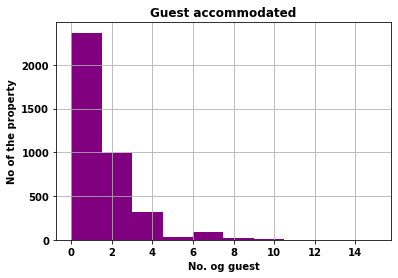

In [8]:
l_df['guests_included'].hist(color = 'purple')
plt.ylabel("No of the property")
plt.xlabel('No. og guest')
plt.title("Guest accommodated");

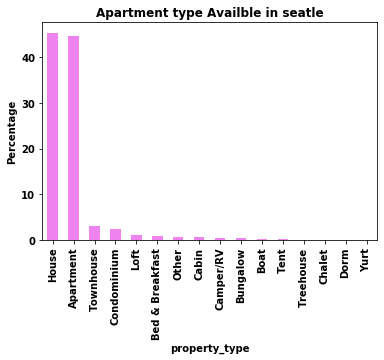

In [9]:
# plotting the percentage of property type available in seatle
apart_vals = l_df['property_type'].value_counts()
(apart_vals/l_df.shape[0]*100).plot(kind="bar",color = 'violet');
plt.ylabel("Percentage")
plt.xlabel('property_type')
plt.title("Apartment type Availble in seatle");

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

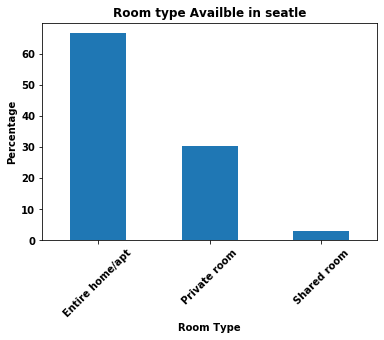

In [85]:
# plotting the percentage of room type available in seatle
apart_vals = l_df['room_type'].value_counts()
(apart_vals/l_df.shape[0]*100).plot(kind="bar");
plt.ylabel("Percentage")
plt.xlabel('Room Type')
plt.title("Room type Availble in seatle");
plt.xticks(rotation=45)

Text(0.5, 1.0, 'No. of accommodate in different property')

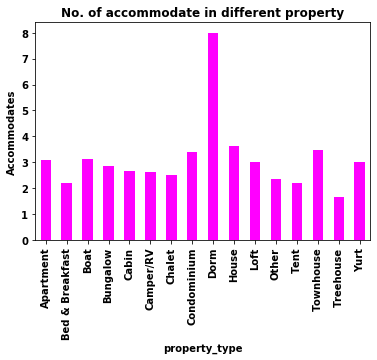

In [84]:
l_df.groupby(['property_type']).mean()['accommodates'].plot(kind='bar',color='magenta')
plt.ylabel('Accommodates')
plt.title("No. of accommodate in different property")


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

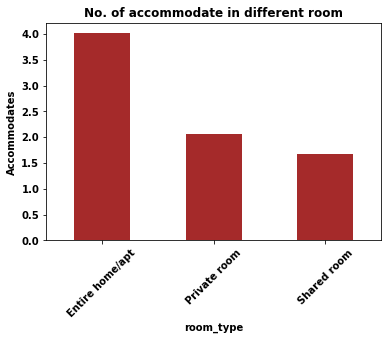

In [82]:
l_df.groupby(['room_type']).mean()['accommodates'].plot(kind='bar',color = 'brown')
plt.ylabel('Accommodates')
plt.title("No. of accommodate in different room")
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Average rating with percentage')

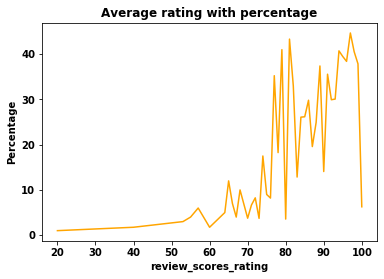

In [13]:
# See what is the max no. of rating customer has giver
l_df.groupby(['review_scores_rating']).mean()['number_of_reviews'].plot(kind='line',color='orange')
plt.ylabel("Percentage")
plt.title("Average rating with percentage")

### Checking in which month has more crowd in Seattle

In [54]:
r_df['month'] = pd.DatetimeIndex(r_df['date']).month

In [65]:
# as the values are in number 1,2,3,4,5,6,7,8,9,10,11,12
# converting them to name of the months
new_index = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [66]:
most_visit = r_df['month'].value_counts().sort_index(axis =0)
most_visit.index = pd.Categorical(most_visit.index).rename_categories(new_index)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

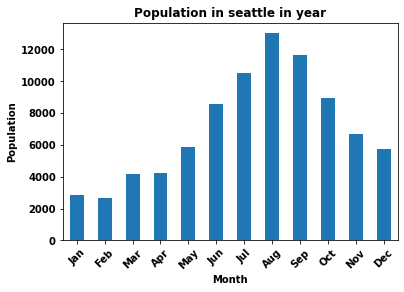

In [81]:
(most_visit).plot(kind = 'bar')
plt.ylabel("Population")
plt.xlabel("Month")
plt.title("Population in seattle in year")
plt.xticks(rotation=45)

### Q1 Checking the most common amenity avialable in the properties

In [14]:
type(l_df['amenities'][0])

str

In [15]:
# coverting string to clean list of elements
def str_to_list(text):
    s = text.split(",")
    l = [i.translate(str.maketrans('', '', string.punctuation)) for i in s]
    return l
    

In [16]:
l_df['amenities']=l_df['amenities'].apply(str_to_list)

In [17]:
l_df['amenities']

0       [TV, Cable TV, Internet, Wireless Internet, Ai...
1       [TV, Internet, Wireless Internet, Kitchen, Fre...
2       [TV, Cable TV, Internet, Wireless Internet, Ai...
3       [Internet, Wireless Internet, Kitchen, Indoor ...
4       [TV, Cable TV, Internet, Wireless Internet, Ki...
                              ...                        
3813    [TV, Cable TV, Internet, Wireless Internet, Ai...
3814    [TV, Cable TV, Internet, Wireless Internet, Ki...
3815    [Cable TV, Wireless Internet, Kitchen, Free Pa...
3816    [TV, Wireless Internet, Kitchen, Free Parking ...
3817    [TV, Cable TV, Internet, Wireless Internet, Ki...
Name: amenities, Length: 3818, dtype: object

In [18]:
#set MultiLabelBinarizer to separate amenities
mlb = MultiLabelBinarizer()
amenities = pd.DataFrame(mlb.fit_transform(
    l_df['amenities']), columns=mlb.classes_, index=l_df['amenities'].index)

# Sum the amenities labels
amenities_c=amenities.sum().sort_values(ascending=False)
print('There are {0} kinds of amenities'.format(len(amenities.columns)))

There are 42 kinds of amenities


In [37]:
amenities_c[:10]

Wireless Internet    3667
Heating              3627
Kitchen              3423
Smoke Detector       3281
Essentials           3237
Dryer                2997
Washer               2992
Internet             2811
Shampoo              2670
TV                   2574
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

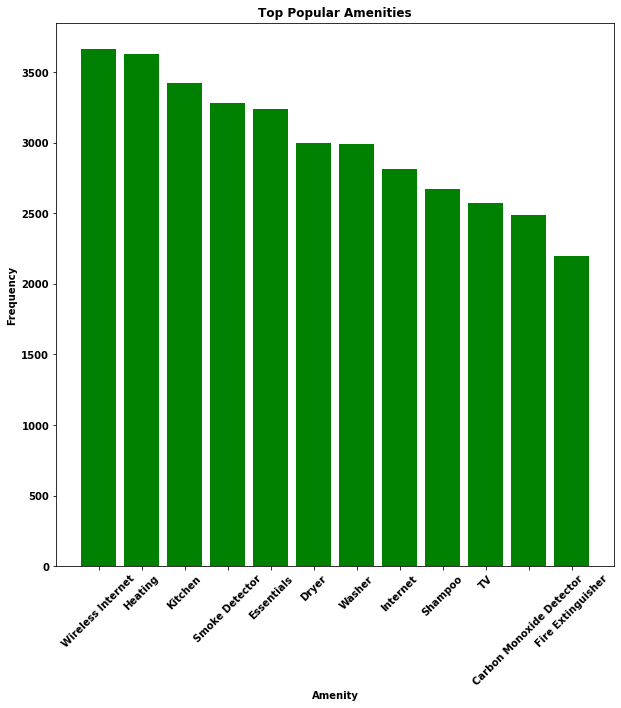

In [80]:
plt.figure(figsize=(10,10))
plt.bar(amenities_c[:12].index,amenities_c[:12].values,color='g')
plt.title('Top Popular Amenities')
plt.xlabel('Amenity')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

### Understanding price feature 

### Alse plotting the location of the property with price range

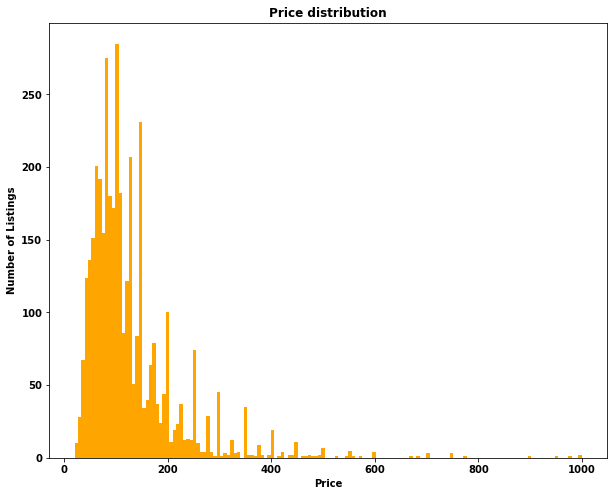

In [21]:

# Plot the price distribution
plt.figure(figsize=(10, 8))
plt.hist(l_df.price, bins=150, color='orange')
plt.title('Price distribution')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.show()

In [22]:
# taking out the month from the calendar.csv
c_df['month'] = pd.DatetimeIndex(c_df['date']).month 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

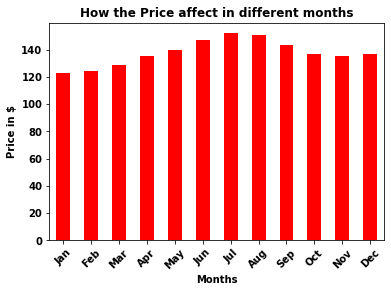

In [86]:
# plotting the price by grouping with the months
most_price = c_df.groupby(['month']).mean()['price']
most_price.index = pd.Categorical(most_visit.index).rename_categories(new_index)
most_price.plot(kind="bar",color='red')
plt.ylabel("Price in $")
plt.xlabel("Months")
plt.title("How the Price affect in different months")
plt.xticks(rotation=45)
# price is generally high in july 

Text(0.5, 1.0, 'How the Price affect in different property type')

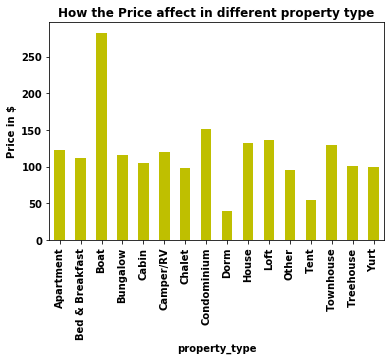

In [36]:
# plotting the price by grouping with the property type
l_df.groupby(['property_type'])['price'].mean().plot(kind="bar",color='y')
plt.ylabel("Price in $")
plt.title("How the Price affect in different property type")
### answer  boats are costlier

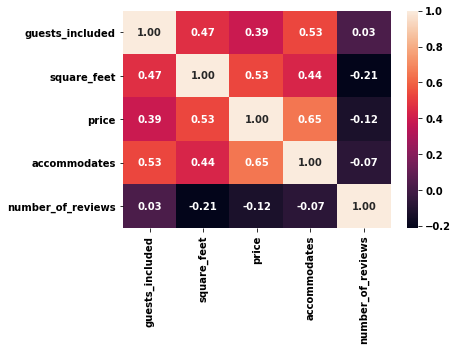

In [25]:
### correlation of price with other feature showing only the features which actually affect
l = ['guests_included','square_feet','price','accommodates','number_of_reviews',]
sns.heatmap(l_df[l].corr(), annot = True, fmt='.2f')

In [26]:
# Plot the locations of the property from the listing.csv
import plotly.express as plte
loc = l_df[['state','city', 'latitude', 'longitude', 'price']]

plte.set_mapbox_access_token('pk.eyJ1Ijoibm90aWtlODc3IiwiYSI6ImNrNWFxcmZmczEyeTgzbHAzYnRicmhxeWEifQ.xRoAbQ4k6NQ35Dw2AGaeBA')
fig = plte.scatter_mapbox(loc[loc['price']<=800], lat="latitude", lon="longitude", color="price",
                        color_continuous_scale=plte.colors.sequential.Viridis, zoom=10)
fig.show()


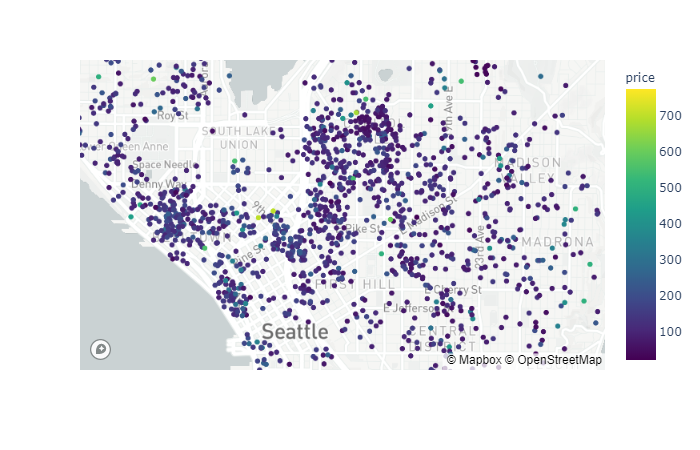

In [27]:
from IPython.display import Image
Image(filename='newplot.png')


In [28]:
c_price = loc.groupby(
    'city')['price'].mean().sort_values(ascending=False)
top10 = pd.DataFrame(
    {'city': c_price[:10].index, 'average': c_price[:10].values})
top10.head(n=10).style.format(
    {'average': "${:.0f}"}).background_gradient(cmap='Blues')

### Q2. How many unverified host has verfied exact location and unverified exact location. And Vise Versa??

Text(0.5, 1.0, 'Verified host property exact location status')

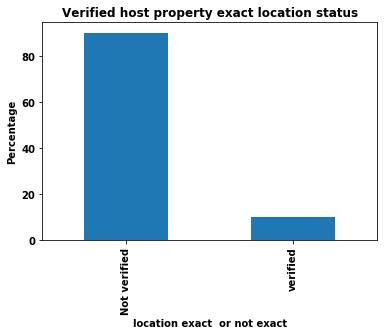

In [76]:
# plotting the percentage of 

count_t = l_df[l_df['host_identity_verified']=='t']['is_location_exact'].value_counts()
tot_= l_df[l_df['host_identity_verified']=='t']['is_location_exact'].shape[0]
newIndex = ['verified','Not verified']
count_t.index = pd.Categorical(count_t.index).rename_categories(newIndex)
(count_t/tot_*100).plot(kind='bar')
plt.ylabel("Percentage")
plt.xlabel("location exact  or not exact")
plt.title("Verified host property exact location status")

Text(0.5, 1.0, "Unverified host's property exact location status")

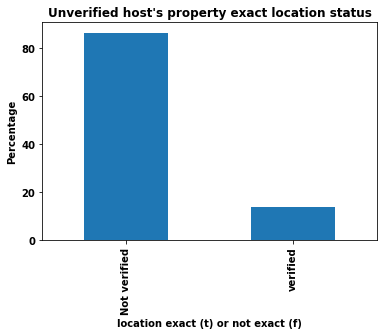

In [78]:
count_t = l_df[l_df['host_identity_verified']=='f']['is_location_exact'].value_counts()
tot_= l_df[l_df['host_identity_verified']=='f']['is_location_exact'].shape[0]
count_t.index = pd.Categorical(count_t.index).rename_categories(newIndex)
(count_t/tot_*100).plot(kind='bar')
plt.ylabel("Percentage")
plt.xlabel("location exact (t) or not exact (f)")
plt.title("Unverified host's property exact location status")

In [91]:
l_df.select_dtypes(include='object').columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
       'state', 'zipcode', 'market', 'smart_location', 'country_code',
       'country', 'is_location_exact', 'property_type', 'room_type',
       'bed_type', 'amenities', 'calendar_updated', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'jurisdiction_names', 'instant_bookable',
       'cancellation_policy', 'require_guest_

### Q3 How increase rental of the property what words to use to name it and what words to using in descriptions??


In [88]:
# getting all the text like name , summmary, description, neighbourhood 
l_df['text'] = l_df['summary']+ " "+ l_df['description']+" "+l_df['transit']+" "+l_df['neighbourhood_cleansed']

In [89]:
# coverting everything to str so that we can split
l_df['text'] = l_df.text.astype(str)

In [90]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [91]:
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [92]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_pos(pos[0][1]))
            final_text.append(word.lower())
    return " ".join(final_text)      

In [93]:
l_df.text = l_df.text.apply(lemmatize_words)

Text(0.5, 1.0, 'Vibe of seattle')

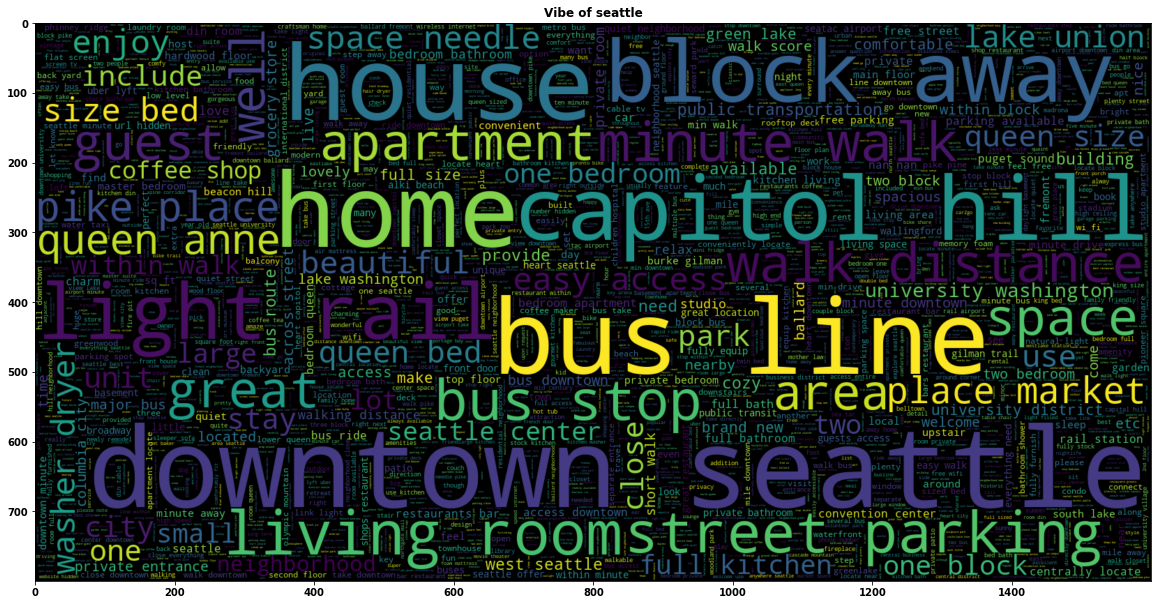

In [94]:
# plots the word cloud of the words should be used to get people's attention
plt.figure(figsize = (20,20)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(l_df.text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Vibe of seattle")

### Understating customer review on an average

### Sentiment analysis of the reviews of the customer

In [187]:
### sentiments analysis from the review.csv using the comments for natural language property
SIA = SentimentIntensityAnalyzer()
for sentence in r_df['comments'].values[:3]:
    print(sentence,"\n")
    ss = SIA.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
    print("\n")


Cute and cozy place. Perfect location to everything!  

compound: 0.7901, 
neg: 0.0, 
neu: 0.462, 
pos: 0.538, 


Kelly has a great room in a very central location. 
Beautiful building , architecture and a style that we really like. 
We felt guite at home here and wish we had spent more time.
Went for a walk and found Seattle Center with a major food festival in progress. What a treat.
Visited the Space Needle and the Chihuly Glass exhibit. Then Pikes Place Market. WOW.  Thanks for a great stay. 

compound: 0.9872, 
neg: 0.0, 
neu: 0.609, 
pos: 0.391, 


Very spacious apartment, and in a great neighborhood.  This is the kind of apartment I wish I had!

Didn't really get to meet Kelly until I was on my out, but she was always readily available by phone. 

I believe the only "issue" (if you want to call it that) was finding a place to park, but I sincerely doubt its easy to park anywhere in a residential area after 5 pm on a Friday 

compound: 0.8718, 
neg: 0.043, 
neu: 0.772, 
pos: 0.18

In [56]:

def get_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]


In [58]:
reviews_f = [r for r in r_df['comments'] if pd.notnull(r) and get_language(r) == 'english']

In [68]:
pscores = [SIA.polarity_scores(comment) for comment in reviews_f]

In [72]:
pscores[0]

{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'compound': 0.7901}

Text(0.5, 0, 'positivity')

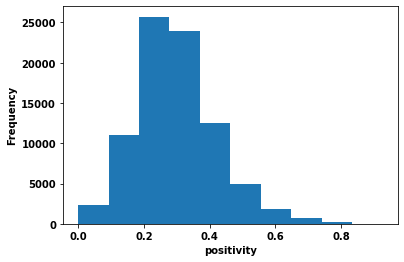

In [142]:
#positive review by the customer
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')
plt.xlabel('positivity')


Text(0.5, 0, 'negativity')

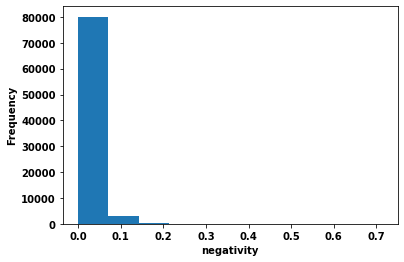

In [143]:
# negative review by the customer
pd.Series([score['neg'] for score in pscores]).plot(kind='hist')
plt.xlabel('negativity')

In [75]:
p = [TextBlob(comment).sentiment for comment in reviews_f]

Text(0.5, 0, 'Polarity of the comment')

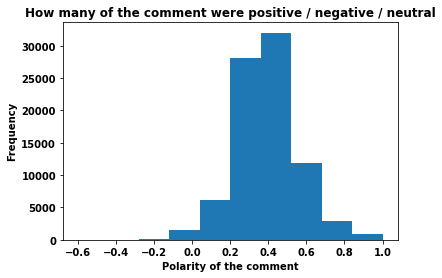

In [147]:
#Polarity in the  reviews of the customer
pd.Series([score[0] for score in p]).plot(kind='hist')
plt.title("How many of the comment were positive / negative / neutral")
plt.xlabel("Polarity of the comment")

Text(0.5, 0, 'Subjectivity of the comment')

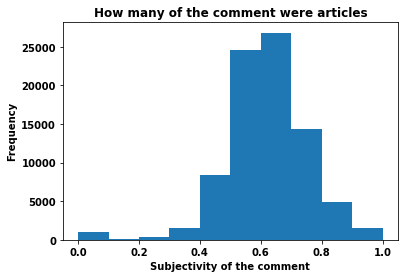

In [146]:
#Subjectivity in the  reviews of the customer
pd.Series([score[1] for score in p]).plot(kind='hist')
plt.title("How many of the comment were articles")
plt.xlabel("Subjectivity of the comment")

In [105]:
reviews_f = pd.DataFrame(reviews_f,columns=['clean_review'])

In [109]:
reviews_f["sentiments"] = reviews_f["clean_review"].apply(lambda x: SIA.polarity_scores(x))

0.538

In [125]:
def get_po(dic):
    return dic['pos']
def get_ne(dic):
    return dic['neg']
def get_nu(dic):
    return dic['neu']


In [122]:
reviews_f["pos"] = reviews_f["sentiments"].apply(get_po)


In [126]:
reviews_f["neg"] = reviews_f["sentiments"].apply(get_ne)
reviews_f["neu"] = reviews_f["sentiments"].apply(get_nu)

In [141]:
### checking the neutral comment like how many of the neutral comments were positive or negative

Text(0, 0.5, 'Percentage')

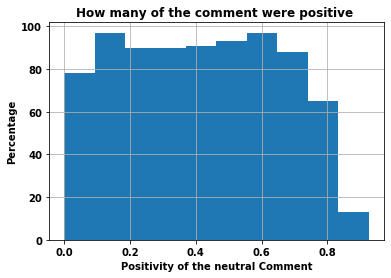

In [150]:
reviews_f.groupby(['neu']).mean()['pos'].hist()
plt.title("How many of the comment were positive ")
plt.xlabel("Positivity of the neutral Comment")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage')

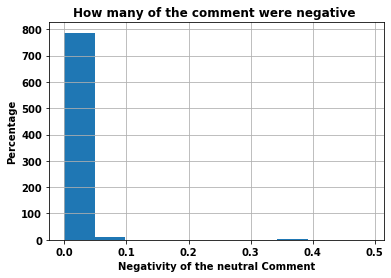

In [151]:
reviews_f.groupby(['neu']).mean()['neg'].hist()
plt.title("How many of the comment were negative ")
plt.xlabel("Negativity of the neutral Comment")
plt.ylabel("Percentage")